In [1]:
# Data Set: FD001
# Train trajectories: 100
# Test trajectories: 100
# Conditions: ONE (Sea Level)
# Fault Modes: ONE (HPC Degradation)

# Data Set: FD002
# Train trajectories: 260
# Test trajectories: 259
# Conditions: SIX 
# Fault Modes: ONE (HPC Degradation)

# Data Set: FD003
# Train trajectories: 100
# Test trajectories: 100
# Conditions: ONE (Sea Level)
# Fault Modes: TWO (HPC Degradation, Fan Degradation)

# Data Set: FD004
# Train trajectories: 248
# Test trajectories: 249
# Conditions: SIX 
# Fault Modes: TWO (HPC Degradation, Fan Degradation)


In [101]:
# Reference: https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/

from IPython.display import HTML
import numpy as np
import pandas as pd
import calmap
import warnings
import itertools
import os
import shutil
import datetime
import seaborn as sns
import matplotlib.ticker as plticker
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from category_encoders import *
from scipy.stats import pearsonr
from scipy.fftpack import fft
from scipy.signal import butter, lfilter, freqz, stft

from sklearn.metrics import mean_squared_log_error, mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, KFold, cross_val_score 
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.base import clone

from lightgbm import LGBMRegressor
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_log_error
from math import sqrt

warnings.filterwarnings('ignore')
dataPath = '../data/'
pd.set_option('display.max_columns', None)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#### 1. Restructure dataset(s)

In [3]:
train = pd.read_csv('../data/train_FD001.txt', sep=" ", header=None)
train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


- last 2 cols are 'nan': drop these

In [4]:
train.drop(train.columns[-2:], axis = 1, inplace = True)

##### Rename columns:

In [5]:
cols = ['unit_num', 'cycle']
opSetCols = ['opSetting' + str(i) for i in range(1,4)]
sensorCols = ['sensor' + str(i) for i in range(1,29-7)]
cols += opSetCols + sensorCols
len(train.columns), len(cols)

(26, 26)

In [6]:
train.columns = cols
train.head(2)

,unit_num,cycle,opSetting1,opSetting2,opSetting3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236


In [7]:
train.shape, len(train.unit_num.unique()), len(train.cycle.unique())

((20631, 26), 100, 362)

##### Create target variable: 
- Choose maximum cycle for all units as failure
- Reverse order of cycles and set target variable equal to 'CyclesToFailure'

In [8]:
max_cycle = train.groupby('unit_num')['cycle'].max().reset_index()
max_cycle.rename(columns={'cycle': 'max_cycle'}, inplace = True)
max_cycle.head(2)

,unit_num,max_cycle
0,1,192
1,2,287


In [9]:
train = train.merge(max_cycle, left_on='unit_num', right_on='unit_num', how='outer')
train.head(2)

,unit_num,cycle,opSetting1,opSetting2,opSetting3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,max_cycle
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,192
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,192


In [10]:
train['CyclesToFailure'] = train.max_cycle - train.cycle
train.drop(['cycle', 'max_cycle'], axis = 1, inplace = True)
train.head(2)

,unit_num,opSetting1,opSetting2,opSetting3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,CyclesToFailure
0,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190


#### 2. EDA
- Feature analysis
- Correlations with target variable
- missing-values
- outliers
- etc

##### Check for nan's

In [11]:
def checkMissingData(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data.head()

In [12]:
checkMissingData(train)

,Total,Percent
CyclesToFailure,0,0.0
sensor21,0,0.0
opSetting1,0,0.0
opSetting2,0,0.0
opSetting3,0,0.0


- no missing data

##### Determine if some features are categorical or not:
- determine also whether some features are also redundant

In [13]:
for i, col in enumerate(train.columns[1:-1]):
    print(len(train[col].value_counts()), end = ', ')
    #print('column_{}'.format(i+1), ' unique_values = {}'.format(len(train[col].value_counts())), end = ' | ')

158, 13, 1, 1, 310, 3012, 4051, 1, 2, 513, 53, 6403, 1, 159, 427, 56, 6078, 1918, 1, 13, 1, 1, 120, 4745, 

- Clearly some features are useless as they do not provide more than one type of value
    - remove columns 3, 4, 8, 13, 19, 21, 22

In [14]:
colIndicesToDrop = [3, 4, 8, 13, 19, 21, 22]
colsToDrop = []
for i, col_index in enumerate(colIndicesToDrop):
    colsToDrop.append(train.columns[col_index])
train.drop(colsToDrop, axis = 1, inplace = True)
train.head()

,unit_num,opSetting1,opSetting2,sensor2,sensor3,sensor4,sensor6,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,CyclesToFailure
0,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187


In [15]:
print(train.columns)

Index(['unit_num', 'opSetting1', 'opSetting2', 'sensor2', 'sensor3', 'sensor4',
       'sensor6', 'sensor7', 'sensor8', 'sensor9', 'sensor11', 'sensor12',
       'sensor13', 'sensor14', 'sensor15', 'sensor17', 'sensor20', 'sensor21',
       'CyclesToFailure'],
      dtype='object')


In [16]:
for i, col in enumerate(train.columns[1:-1]):
    print(len(train[col].value_counts()), end = ', ')
    #print('column_{}'.format(i+1), ' unique_values = {}'.format(len(train[col].value_counts())), end = ' | ')

158, 13, 310, 3012, 4051, 2, 513, 53, 6403, 159, 427, 56, 6078, 1918, 13, 120, 4745, 

##### Check correlations with target variable 
- check for individual unit_numbers

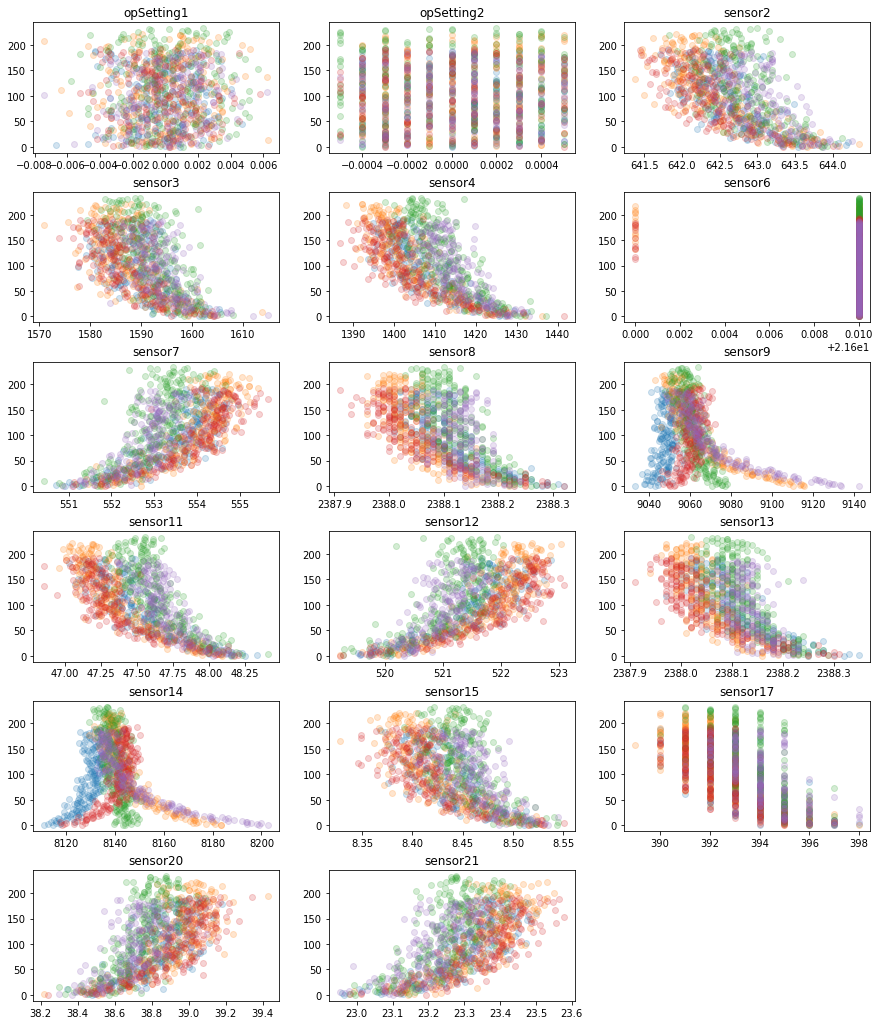

In [17]:
unit_num_list = [1, 10, 20, 30, 40]              # Selected unit-numbers

colList = train.columns[1:-1]
n_cols = 3                                       # 3 plots per row
rows = int(np.ceil(len(colList) / n_cols))    
f = plt.figure(figsize=(15,3*rows))

for i, col in enumerate(colList):
    
    axi = f.add_subplot(rows, n_cols, i+1)
    for i, unit_num in enumerate(unit_num_list):
        df = train[train.unit_num == unit_num]
        plt.scatter(df[col], df.CyclesToFailure, alpha = 0.2)# label = col + '_unit' + str(unit_num), alpha = 0.2)

    plt.title(col)
    
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)

- clearly sensor17 and opSetting2 are categorical variables:
        - set their values to categorical numerical values

In [18]:
le = LabelEncoder()
cat_vars = ['sensor17', 'opSetting2']
for var in cat_vars:
      train[var] = le.fit_transform(train[var])

In [19]:
train.head(2)

,unit_num,opSetting1,opSetting2,sensor2,sensor3,sensor4,sensor6,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,CyclesToFailure
0,1,-0.0007,2,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,4,39.06,23.4190,191
1,1,0.0019,3,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,4,39.00,23.4236,190


In [20]:
train.dtypes

unit_num             int64
opSetting1         float64
opSetting2           int64
sensor2            float64
sensor3            float64
sensor4            float64
sensor6            float64
sensor7            float64
sensor8            float64
sensor9            float64
sensor11           float64
sensor12           float64
sensor13           float64
sensor14           float64
sensor15           float64
sensor17             int64
sensor20           float64
sensor21           float64
CyclesToFailure      int64
dtype: object

##### Heat Map

- Take unit-1 as an example

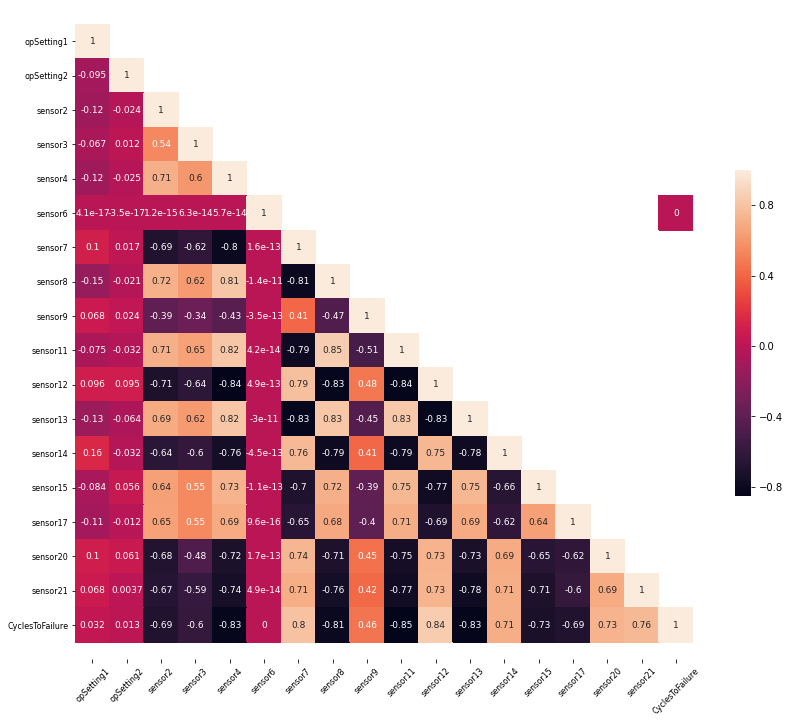

In [21]:
df = train[train.unit_num == 1]
df.drop(['unit_num'], axis = 1, inplace = True)
cor_mat= df[2:].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig = plt.gcf()
fig.set_size_inches(15,12)
ax = sns.heatmap(data=cor_mat,mask=mask,square=True,cbar_kws={"shrink": .5}, annot=True,cbar=True, annot_kws={"fontsize":9})
ylim_lower = (ax.get_ylim()[0] + 0.5)
ylim_upper = (ax.get_ylim()[1] - 0.5)
ax.set_ylim(ylim_lower, ylim_upper)
plt.xticks(rotation=45, fontsize = 8) 
_ = plt.yticks(rotation=0, fontsize = 8) 

- Sensor 6 clearly shows very little correlation with failure as seen in the scatter plot above
    - confirm with pearsons correlation for all unit-numbers:

In [22]:
train.sensor6.value_counts()

21.61    20225
21.60      406
Name: sensor6, dtype: int64

In [23]:
train.drop(['sensor6'], axis = 1, inplace = True)

- Further visualisation:
    - Scale each feature (holding unit_number constant) and then convert all to PCA 

In [41]:
def scaleData(df):
    mm = MinMaxScaler() #StandardScaler()
    df_ = df.copy()
    df_[df_.columns[1:-1]] = mm.fit_transform(df[df.columns[1:-1]])
    return df_

def convertToPCA(df, nComponents):
    pca = PCA(n_components=nComponents)
    pcaColList = [("PC" + str(x)) for x in range(nComponents)]
    pcaX = pca.fit_transform(df[df.columns[:-1]])
    df_PCA = pd.DataFrame(pcaX, columns=pcaColList)
    df_PCA['FailureGrade'] = df.FailureGrade.values
    return df_PCA

In [42]:
list_dfs = []
for unit_number in train.unit_num.unique():
    df = train[train.unit_num == unit_number]
    df_ = scaleData(df)
    list_dfs.append(df_)
    
train_ = pd.concat(list_dfs)

In [43]:
train.columns

Index(['unit_num', 'opSetting1', 'opSetting2', 'sensor2', 'sensor3', 'sensor4',
       'sensor7', 'sensor8', 'sensor9', 'sensor11', 'sensor12', 'sensor13',
       'sensor14', 'sensor15', 'sensor17', 'sensor20', 'sensor21',
       'CyclesToFailure'],
      dtype='object')

##### Set classes as follows:
- x < 70%         CyclesToFailure 
    - normal working condition
- 70% <= x < 90% CyclesToFailure           
    - degraded working condition
- 90% <= x       CyclesToFailure           
    - failing working condition

In [44]:
list_dfs = []
for unit_number in train_.unit_num.unique():
    df = train[train.unit_num == unit_number]
    df['FailureGrade'] = 0
    max_cycle = max(df.CyclesToFailure)
    mod_threshold = int(0.3*max_cycle)
    fail_threshold = int(0.1*max_cycle)
    df.loc[df.CyclesToFailure <= mod_threshold, 'FailureGrade'] = 1
    df.loc[df.CyclesToFailure <= fail_threshold, 'FailureGrade'] = 2
    list_dfs.append(df)
train_ = pd.concat(list_dfs)
train_.tail()

,unit_num,opSetting1,opSetting2,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,CyclesToFailure,FailureGrade
20626,100,-0.0004,3,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,9,38.49,22.9735,4,2
20627,100,-0.0016,1,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,7,38.30,23.1594,3,2
20628,100,0.0004,6,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,10,38.44,22.9333,2,2
20629,100,-0.0011,9,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,7,38.29,23.0640,1,2
20630,100,-0.0032,1,643.85,1600.38,1432.14,550.79,2388.26,9061.48,48.20,519.30,2388.26,8137.33,8.5036,8,38.37,23.0522,0,2


##### Remove unit_num and convert all scaled values to 2 PCA components
- visualise their distributions according to the 3 predefined classes above 

In [45]:
train_.drop('unit_num', axis = 1, inplace = True)
df = convertToPCA(train_, nComponents = 2)

In [46]:
df.head()

,PC0,PC1,FailureGrade
0,85.495886,-2.866869,0
1,85.195416,-9.287978,0
2,82.920858,-1.871779,0
3,82.825745,-4.206032,0
4,80.636903,-0.289944,0


- Classes are clearly quite separable (slight overlap with failure-grades '0' and '1' as seen in plot below:

<Figure size 1080x216 with 0 Axes>

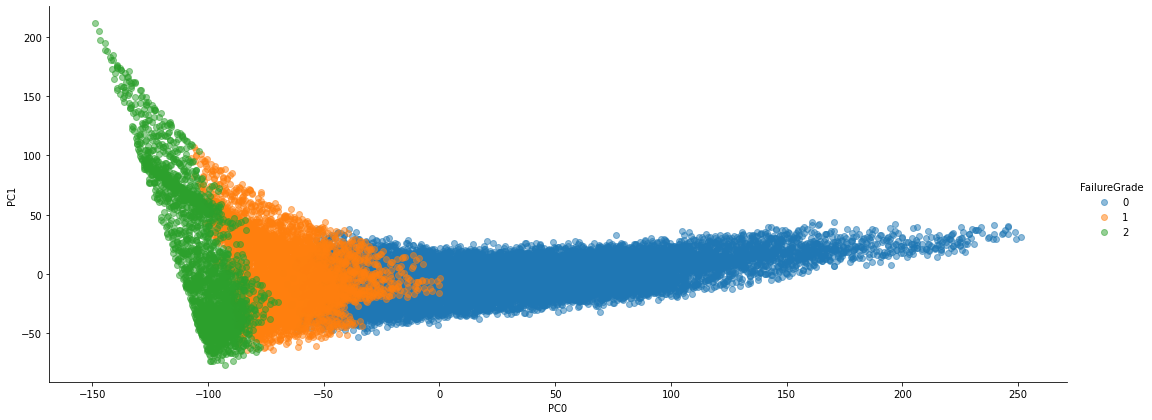

In [60]:
# Visualise failure grades through colours:
f = plt.figure(figsize=(15,3))
explore = sns.PairGrid(data=df, x_vars = 'PC0', y_vars = 'PC1', hue="FailureGrade", size=6, aspect=2.5)
explore = explore.map(plt.scatter, alpha=0.5)
explore = explore.add_legend()

##### 3 Component PCA

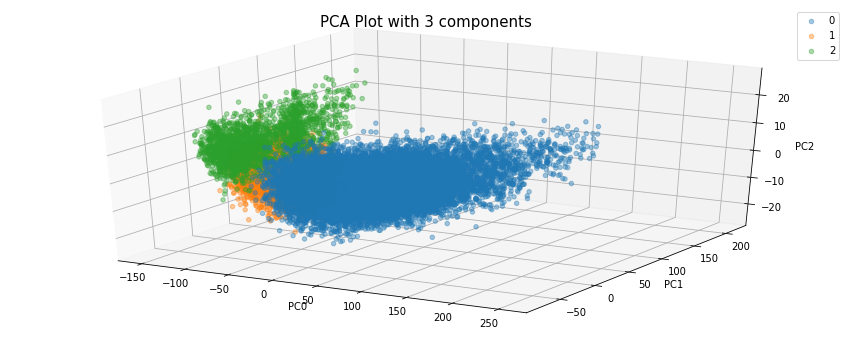

In [77]:
f = plt.figure(figsize=(15,6))
ax = f.add_subplot(111, projection='3d')

for failure_grade in df.FailureGrade.unique():
    df_ = df[df.FailureGrade == failure_grade]
    ax.scatter(df_.PC0, df_.PC1, df_.PC2, marker='o', label = str(failure_grade), alpha = 0.4)

ax.set_xlabel('PC0')
ax.set_ylabel('PC1')
ax.set_zlabel('PC2')
plt.legend()
plt.title('PCA Plot with 3 components', fontsize = 15)
plt.show()

#### Quick test of model:

In [ ]:
train_.drop(['FailureGrade', 'opSetting1', 'opSetting2'], axis = 1, inplace = True)


In [88]:
train_.head()

,opSetting1,opSetting2,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,CyclesToFailure,FailureGrade
0,-0.0007,2,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,4,39.06,23.4190,191,0
1,0.0019,3,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,4,39.00,23.4236,190,0
2,-0.0043,9,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,2,38.95,23.3442,189,0
3,0.0007,6,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,4,38.88,23.3739,188,0
4,-0.0019,4,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,5,38.90,23.4044,187,0


In [106]:
#### ---------------------------------- HELPER FUNCTIONS --------------------------------------------------------------------

def run_train_test_split(df, estimator):
    X = df.drop(['CyclesToFailure'], axis = 1).values
    y = df.drop(df.columns.difference(['CyclesToFailure']), axis = 1).values
    rmsle_scorer = make_scorer(rmsle, greater_is_better=False)
    cval = cross_val_score(estimator, X, y, scoring=rmsle_scorer, cv=4, n_jobs = -1)
    
    print('cross-validation mean score = {}'.format(cval.mean()))
    print("Features sorted by their score:")
    print(sorted(zip(map(lambda x: round(x, 4), rfModel.feature_importances_), predX.columns), 
             reverse=True))
    
    return 

## -----------------------------------------------------------------------------------------------------------------------

def testModel(df, n_splits, model, returnVal = False, printOutput = True):

    X = df.drop(['CyclesToFailure'], axis = 1).values
    y = df.drop(df.columns.difference(['CyclesToFailure']), axis = 1).values
    kf = KFold(n_splits, True, 1)
    rmsleScores = []
    
    if printOutput:
        print("RMSLE Value For Kf_i: ", end = ' ')
    for train_index, test_index in kf.split(X):
        trainX, testX = X[train_index], X[test_index]
        trainy, testy = y[train_index], y[test_index]
        model_ = clone(model)
        model_.fit(trainX,trainy)
        preds = model_.predict(testX)
        rmsleScore = rmsle(np.exp(testy), np.exp(preds))
        rmsleScores.append(rmsleScore)
        if printOutput:
            print(round(rmsleScore, 2), end = ', ')
    if printOutput:
        print ("Average RMSLE: ", round(sum(rmsleScores) / n_splits, 3))
        print("Features sorted by their score:")
        print(sorted(zip(map(lambda x: round(x, 4), model_.feature_importances_), df.columns[:-1]), 
             reverse=True))
    if returnVal:
        return round(sum(rmsleScores) / n_splits, 3)
    
#### ---------------------------------- LOSS FUNCTION --------------------------------------------------------------------

def rmsle(ytrue, ypred):
    try:
        return np.sqrt(mean_squared_log_error(ytrue, ypred))
    except ValueError:
        return np.sqrt(mean_squared_log_error(ytrue + 100, ypred + 100)) # prevent negative log-values   

In [107]:
rfModel = RandomForestRegressor(n_estimators=100)
#run_train_test_split(train, rfModel)testModel
testModel(train, 4, rfModel, returnVal = False, printOutput = True)


RMSLE Value For Kf_i:  29.99, 30.75, 30.97, 30.35, Average RMSLE:  30.514
Features sorted by their score:
[(0.4339, 'sensor11'), (0.1218, 'unit_num'), (0.1144, 'sensor9'), (0.0804, 'sensor4'), (0.0408, 'sensor12'), (0.0335, 'sensor14'), (0.03, 'sensor7'), (0.0209, 'sensor15'), (0.019, 'sensor21'), (0.0165, 'sensor13'), (0.0162, 'sensor20'), (0.016, 'sensor3'), (0.0157, 'sensor2'), (0.0155, 'sensor8'), (0.0114, 'opSetting1'), (0.0077, 'opSetting2'), (0.0062, 'sensor17')]


In [105]:
train_.drop(['CyclesToFailure'], axis = 1, inplace = True).columns

AttributeError: 'NoneType' object has no attribute 'columns'

##### Drop 'opSetting1' and 'opSetting2' given they provide little information:
- Check if they are engaged more/less at different stages of wear

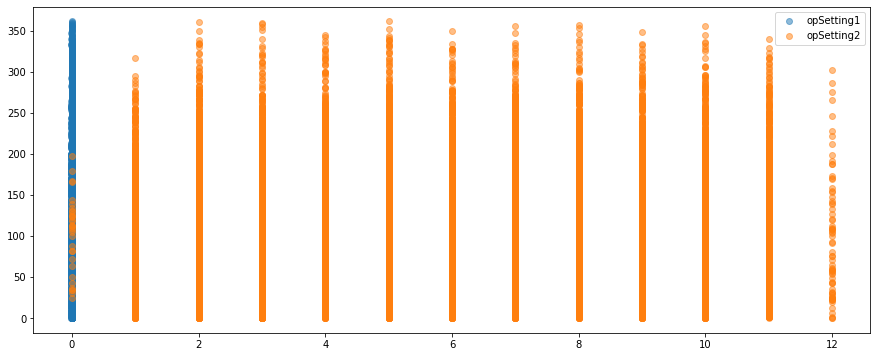

In [86]:
cols = ['opSetting1', 'opSetting2']
f = plt.figure(figsize=(15,6))

for col in cols:
    plt.scatter(train_[col], train_.CyclesToFailure, label = col, alpha = 0.5)
plt.legend()

In [ ]:
#### Remove 'opSetting1' & 'opSetting2' as 

#### Survival analysis needs constant behaviour of covariates with time! No changes allowed!

In [ ]:

['sensor' + str(i) for i in range(1,29-7)]
#colsToDrop = 
#[train.columns[]]
#train.drop